# COMP5318 - Machine Learning and Data Mining 

## Tutorial 3 - MLP

**Semester 1, 2018**

**Objectives:**

* To understand the multi-layer perceptron.
* To become familiar with backpropagation.


**Instructions:**

* Go to File->Open. Drag and drop "lab3_student.ipynb" file to the home interface and click upload. 
* Read the code and complete the exercises.
* To run the cell you can press Ctrl-Enter or hit the Play button at the top. 

Lecturers: Chang Xu

Tutors: Dalu Guo, Jiayan Qiu, Chaoyue Wang, Xinyuan Chen, Zeyu Feng and Sanjeev Sharma.


## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

 ## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate [-1,1], y coordinate [-1,1] and the class {1,-1}.

<IPython.core.display.Javascript object>


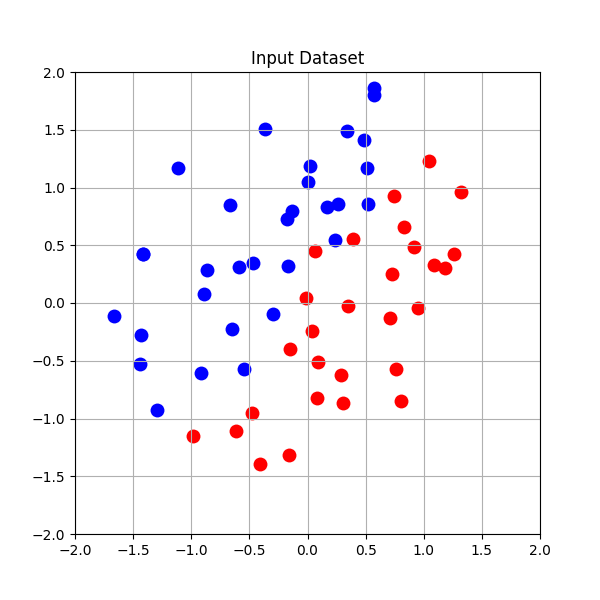

In [2]:
%matplotlib notebook

fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-2,2))
pl.ylim((-2,2))

dataset = []

def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button
    dataset.append((cx, cy, co-2))

    pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
    pl.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [3]:
%matplotlib inline

## Show the dataset

In [4]:
dataset = np.array(dataset)
dataset

array([[-0.89144484,  0.07632222, -1.        ],
       [-0.17746635,  0.72567287, -1.        ],
       [-0.13445559,  0.79493694, -1.        ],
       [ 0.16661968,  0.82956897, -1.        ],
       [-0.54735882, -0.57302843, -1.        ],
       [-0.91725129, -0.60766047, -1.        ],
       [-0.59036957,  0.31008845, -1.        ],
       [-0.46993946,  0.34472049, -1.        ],
       [ 0.00317882,  1.04601919, -1.        ],
       [ 0.02038312,  1.18454733, -1.        ],
       [-0.66778893,  0.84688499, -1.        ],
       [-0.86563839,  0.28411442, -1.        ],
       [-1.43338032, -0.27865614, -1.        ],
       [-1.44198247, -0.52973839, -1.        ],
       [-0.16886419,  0.31874646, -1.        ],
       [ 0.26124333,  0.855543  , -1.        ],
       [ 0.5107057 ,  1.16723131, -1.        ],
       [ 0.48489925,  1.40965555, -1.        ],
       [-0.65058462, -0.22670809, -1.        ],
       [-1.11510075,  1.16723131, -1.        ],
       [-1.66563839, -0.11415397, -1.   

## Definition of some activation functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

In [5]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_derivative(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_derivative
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv

### Define HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [6]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out, W=None, b=None,
                 activation='tanh'):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.activation_deriv=Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            W_values *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta):       
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        # return delta_ for next layer
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta_

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.


In [7]:
class MLP:
    """
    """      
    def __init__(self, layers, activation='tanh'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation=activation))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # write down the delta in the last layer
        delta=error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
        
    def backward(self,delta):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W += lr * layer.grad_W
            layer.b += lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(x[i,:])
        return output

## Learning

In [8]:
### Try different MLP models
nn = MLP([2,1], 'tanh')
input_data = dataset[:,0:2]
output_data = dataset[:,2]

In [9]:
### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.01, epochs=500)
print('loss:%f'%MSE[-1])

loss:0.099646


#### Plot loss in epochs

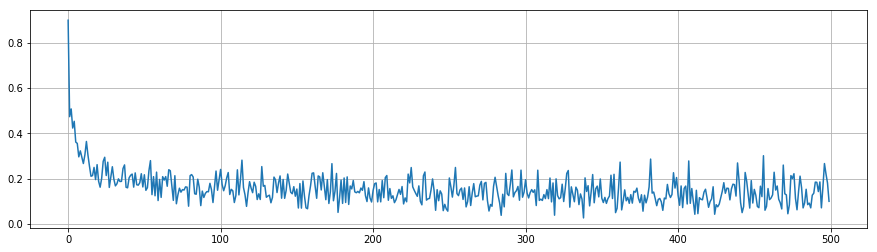

In [10]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

## Testing

In [11]:
output = nn.predict(input_data)

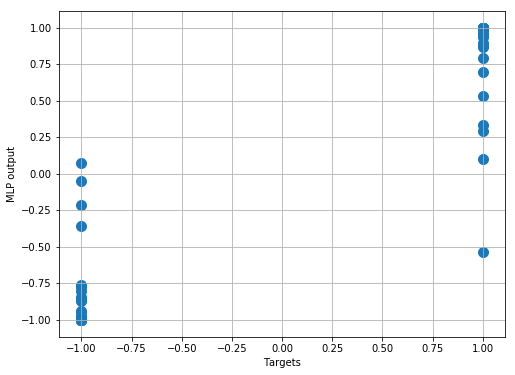

In [12]:
pl.figure(figsize=(8,6))
pl.scatter(output_data, output, s=100)
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.grid()

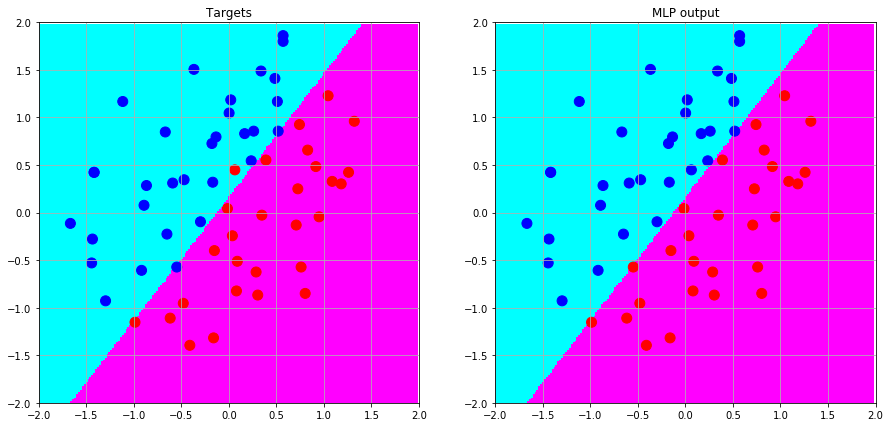

In [13]:
# create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-2, 2, .02),np.arange(-2, 2, .02))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output_data], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('Targets')
pl.subplot(1,2,2)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('MLP output')

## Exercise

- What happens if the boundaries between both classes are well defined?
- What happens if the classes overlap?
- What happens if it is not possible to separate the classes with a single line?
- What happens if the points of one of the classes are separated in subgroups (blobs)?

Try different MLP models in terms of:
- Different layer dimension
- Different layer number

Try different 2D classification problems and observe the behaviour of the algorithm in terms of:
- Learning rate needed
- Convergence speed